### <p style="text-align: right;"> &#9989; Andrew Koren</p>

# PHY480 Homework 1


This homework contains exercises on the following topics:

- errors in numerical calculations,
- numerical derivatives (and gradients),
- root finding with the Newton-Raphson method,
- minimization/maximization with the gradient descent method.

Some of the techniques are illustrated with a projectile motion example.

**There are five problems with the total of 60 points.**

**The deadline for the homework is Friday, Feb. 7, 2025, 6:00 pm.**



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Errors in numerical calculations

**Problem 1 (10 points).** Write a function `sine_series(x,n)` that calculates $\sin(x)$ by summing the Taylor expansion with $n$ terms. (I.e. for $n=1$ $\sin(x)$ is approximated as $x$.) $n$ is provided as a parameter to the function. Calculate $\sin(x)$ with your function at several values and compare to the NumPy `np.sin` to make sure it works properly.

Consider $\sin(\pi/6)$. The exact value is a rational number, let us call it $s_0$ (look it up, it is important to use the exact value here). Calculate the distance between the result of your function for $x=\pi/6$ and $s_0$, defined as $d(n)\equiv |s_0-\text{sine\_series}(x,n)|$. Plot $\ln(d(n))$ as function of $n$ for $n\in[1,14]$.

Taylor's theorem also allows you to estimate the series truncation error, also as function of $n$. On the same figure plot the logarithm of the estimated truncation error for $\sin(x)$ as function of $n$.

Compare the error $d(n)$ that you obtained numerically with the estimated Taylor series truncation error and discuss your findings.


from the interwebs: <br>
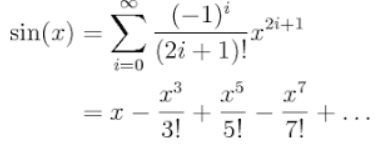

In [12]:
np.sin(np.pi/6)

0.49999999999999994

In [22]:
# approximate sin(x) with Taylor series of n terms
# Input:
# x
# n -- number of terms
# Output:
# approximate sin(x) 

from math import factorial
from numpy import pi

def sine_series( x, n ):
    return sum([(-1)**i/factorial(2*i+1)*x**(2*i+1) for i in range(n)])

d = lambda n: abs(0.5 - sine_series(pi/6, n))

C:\Users\andre\AppData\Local\Temp\ipykernel_34320\29586494.py:3: RuntimeWarning: divide by zero encountered in log
  plt.scatter(n_vals, [np.log(d(n)) for n in n_vals])


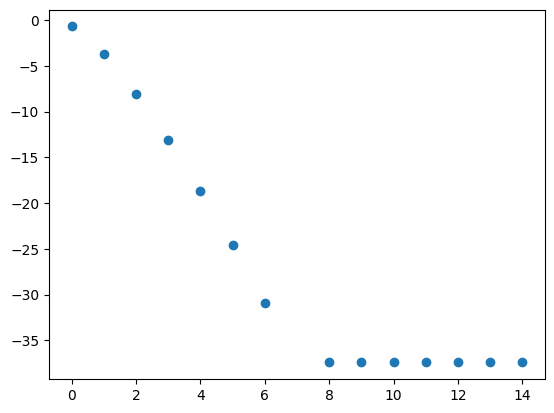

In [33]:
n_vals = np.arange(15) #[0-14] rather than [1-14]

plt.scatter(n_vals, [np.log(d(n)) for n in n_vals])

**Discuss what you observe in this cell.**

The error rapidly decays down to $e^{-35} = 10^{-16}$, but doesn't get any more accurate. This is around the machine accuracy for float64, so it's likely the error shrinks exponentially

In [31]:
np.finfo(type(d(1)))

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

## Gradient

**Problem 2 (10 points).** Write a function that calculates the gradient of a function $f(\vec{r})$, where $\vec{r}$ is a vector of arbitrary dimension $n$, given as a list or NumPy array. (You can read the dimension internally as, e.g., `n=len(r)`.) Use the central finite difference to calculate the gradient. The result to be returned is $\vec{\nabla}f$, -- a NumPy array of size $n$.

To test your function consider a function $f(\vec{r})=\cos(x^2+xy)$. Derive a closed-form expression for its gradient and also program it as a function. Calculate the gradient both ways at different $(x,y)$ points to check that both functions work properly. Print out the result at $(1,1)$.
Calculate the norm of the difference between the exact and approximate gradient at $(1,1)$ for a list of step sizes $\varepsilon$ given below and plot the norm of the difference versus the step size on a log-log plot. (For the norm you can use `np.linalg.norm`.) Discuss your observations.



In [ ]:
# central finite difference
# Input:
# fun -- function to be derived
# x -- at which point
# dim -- input number to vary
# eps -- step size for approximations
def df_central( fun, x, dim=None, eps=0.001, *args):
    if dim==None:
        return (fun(x+eps/2, *args) - fun(x-eps/2, *args))/2

    x = list(x)
    x[dim] += eps/2 # i'm sure messing with x won't cause any problems
    f1 = fun(x, *args)
    x[dim] -= eps
    f2 = fun(x, *args)
    x[dim] += eps/2 # just in case

    return (f1 - f2)/eps


In [38]:
# gradient of a given function
# Input:
# fun -- (scalar) function of a vector argument
# r -- argument of dimension n
# eps -- step size for the central difference approximation
# Output
# gradient as NumPy array of size n

def grad( fun, r, eps=0.001 ):
    
    grad = []
    for dim in range(len(r)):
        partial = df_central(fun, r, dim, eps)
        grad.append(partial)

    return np.array(grad)

In [43]:
# test function
# Input:
# r -- two-dimensional argument
# Output:
# cos( x*x + x*y )
def fcos( r ):
    return np.cos( r[0]*r[0] + r[0]*r[1] )

grad(fcos, (1,1))

array([-2.72789095, -0.90929739])

In [55]:
import sympy as sym

x, y =sym.symbols('x y')
cos_eqn = sym.cos(x*x + x*y)
sym.diff(cos_eqn, y)


-x*sin(x**2 + x*y)

In [58]:
# gradient of test function (analytic)
# Input:
# r -- two-dimensional argument
# Output:
# gradient of cos( x*x + x*y ) as NumPy array of size 2
from numpy import sin

def grad_fcos_theory( r ):
    x, y = r
    return np.array([-(2*x+y)*sin(x*x+x*y), -x*sin(x*x+x*y)])

grad_fcos_theory((1,1))

array([-2.72789228, -0.90929743])

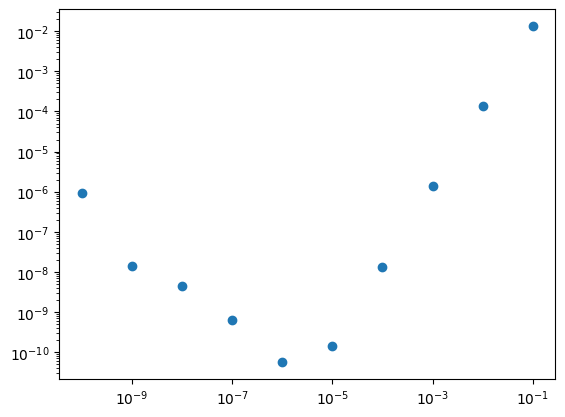

In [74]:
from numpy.linalg import norm

test_location = (1,2)
actual = grad_fcos_theory(test_location)

# list of step sizes
eps_list = [ 1/10**(i+1) for i in range(10) ]

results = []
for eps in eps_list:
    results.append(
        norm(actual - grad(fcos, test_location, eps=eps))
        )

plt.scatter(eps_list, results)
plt.xscale('log')
plt.yscale('log')

**Discuss what you observe in this cell.**

The central finite difference approximates the gradient pretty well for a variety of points, with ~1e-3 for 1e-3 step size. It becomes more accurate as step size increases, but strangely becomes less accurate when steps size is ~1e-6, which is unexpected. This is likely because a very small step size results in very large division in the central finite difference $\Delta f/ \epsilon$, but the $\Delta f$ term isn't garunteed to shrink as evenly, resulting in error

# Root finding


**Problem 3 (20 points).** Consider the following two-dimensional problem on projectile motion (this is similar to a throw in basketball). An object starts with the initial velocity $\vec{v}_0$ from the point $(0,y_0)$. The goal is to adjust the initial angle so that the trajectory passes through a given final point $(x_f,y_f)$. The following is given: $y_0=2$ m, $x_f=4.5$ m, $y_f=3$ m, $v_0=|\vec{v}_0|=7.5$ m/s, the acceleration due to gravity $g=|\vec{g}|=9.8m/s^2$. See the following diagram.


![diagram](HW01_diag.png)


The equation of motion in vector form is:

$$
\vec{r}=\vec{r}_0+\vec{v}_0t+\frac{1}{2}\vec{g}t^2.
$$

In the component form, taking into account the initial conditions:

$$
x = v_0\cos(\theta)\,t
$$
$$
y = y_0+v_0\sin(\theta)\,t-\frac{1}{2}gt^2
$$

Solve the first equation for $t$ and substitute into the second equation. You now have an equation that gives $y$ as function of $x$, i.e., _the equation of the trajectory_ $y(x)$.

Next, substitute the final point $x=x_f$ and $y=y_f$ into $y(x)$ -- you have an equation with a single unknown -- the angle $\theta$ that makes the trajectory pass through the point $(x_f,y_f)$.

This equation involves trigonometic funcitons, rewrite it in the form so that they do not appear in the denominator. You should be able to write the equation for $\theta$ in the form:

$$
f(\theta)=\dots\cos^2(\theta)\dots\dots\sin(\theta)\cos(\theta)\dots\dots\, = 0
$$

(or an equivalent form depending on how you transform expressions with the trigonometric functions).

To solve this equation, program the Newton-Raphson root finding method. It requires the first derivative of $f(\theta)$. Program the Newton-Raphson method such that either the derivative is provided as an argument, or that argument is set to `None` in which case the Newton-Raphson method internally uses the central finite difference.

Program a function to implement the derivative of $f(\theta)$ analytically and solve the equation for $\theta$ with the Newton-Raphson method in two ways: providing the exact analytic derivative and providing `None` (i.e., letting the method internally use the central difference).

You may expect more than one solution. Find all solutions for the the angle $\theta$ and also calculate the time $t$ it takes to reach $(x_f,y_f)$ for all solutions.

$$
x = v_0 \cos(\theta) t \\
t = \frac{x}{v_0 \cos(\theta)} = \frac{4.5}{7.5 \cos(\theta)} \\
\Delta y = \frac{v_0x \sin(\theta)}{v_0 \cos(\theta)}- \frac{gx^2}{2v_0^2 \cos^2(\theta)} \\
1 = 4.5 \tan(\theta)- \frac{198.45}{112.5 \cos^2(\theta)}
$$

In [89]:
from numpy import tan, cos

def trajectory(theta, params):
    v0, x, Dy, g = params
    return x*tan(theta) - g*x*x/(2*v0*v0*(cos(theta))**2)-Dy

In [164]:
# analytical solution
import sympy as sym

th = sym.symbols('theta')

derivative = sym.diff(4.5 * sym.tan(th) - 198.45/(112.5*(sym.cos(th))**2) - 1, th)

def dtrajectory(x):
    return np.float64(derivative.replace(th, x).evalf())

In [307]:
# Newton-Raphson root finding method
# Input:
# fun -- function f(x)
# dfun -- derivative f'(x) or None (use central difference internally)
# x0 -- starting point
# tol -- tolerance, the search stops once |f(x)| is less than the tolerance
# max_iter -- maximum number of iterations
# Output:
# status -- =0, if the search was successful
# x -- the solution (last iterate)
# i -- number of iterations it took
# xlist -- the list of all iterates

def root_newton_raphson( fun, x0, dfun=None, tol=1e-4, max_iter=100 ):
    xn = [x0]
    i = 0
    status = 1

    if dfun==None:
        def dfun(x):
            return df_central(fun, x)

    while abs(fun(xn[-1])) > tol or i == max_iter:
        if dfun(xn[-1]) == 0:
            i = max_iter
            break

        xn1 = xn[-1] - fun(xn[-1])/dfun(xn[-1])
        xn.append(xn1)
        i += 1
    
    if i != max_iter:
        status = 0

    return status, i, xn[-1], fun(xn[-1]), xn

In [ ]:
def preset_trajectory(theta):
    v0 = 7.5
    x = 4.5
    Dy = 1
    g = 9.8
    params = (v0, x, Dy, g)
    return trajectory(theta, params)

numerical_results = []
analyitical_ish_results = []

x0_list = np.linspace(0, 2*pi, 10)
for x0 in x0_list:
    #print('\n', x0)
    # numerical derivative
    status, i, theta, epsilon, steps = root_newton_raphson(preset_trajectory, x0=x0)
    #print(status, theta) # feels like gradient descent might be better in this one
    numerical_results.append(theta % (2*pi))

    # analyitical derivative
    status, i, theta, epsilon, steps = root_newton_raphson(preset_trajectory, x0=x0, dfun=dtrajectory)
    #print(status, theta) # feels like gradient descent might be better in this one
    analyitical_ish_results.append(theta % (2*pi))



angle (rad) and time (s):


[(3.9420445967643616, -0.8615955410289254),
 (0.8004501938861566, 0.8615939877793871),
 (4.130627591005911, -1.0919088380006028),
 (0.9890824251439838, 1.0919876850516133)]

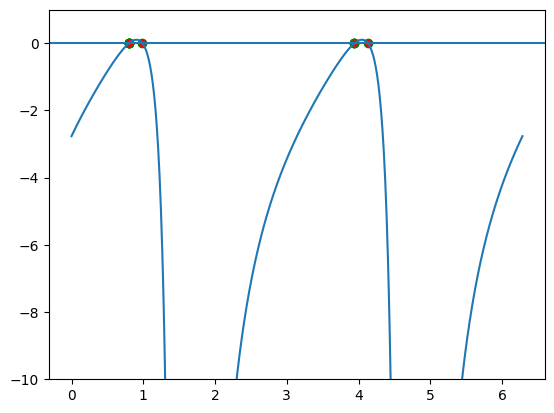

In [211]:
theta_space = np.linspace(0, 2*pi, 1000)
plt.plot(theta_space, preset_trajectory(theta_space))
plt.ylim(-10, 1) #/cos causes problems
plt.axhline(0)
plt.scatter(analyitical_ish_results, preset_trajectory(np.array(analyitical_ish_results)), color='green');
plt.scatter(numerical_results, preset_trajectory(np.array(numerical_results)), s=15, color = 'red');

time = lambda theta: 4.5/(7.5*cos(theta)) # derived at the start

times = time(np.array(numerical_results))

print('angle (rad) and time (s):')
list(zip(numerical_results[:4], times[:4]))

**Problem 4 (5 points).** Now that you found the solutions for the starting angle $\theta$, you can go back to the equation of the trajectory $y(x)$. Code a function that outputs $y$ for a given $x$ on the trajectory (for a given starting angle $\theta$). Plot the trajectories for the angles $\theta$ that you found previously on one plot in the $x$-range $[0,x_f]$. (And check that the trajectories indeed end at $(x_f,y_f)$.)

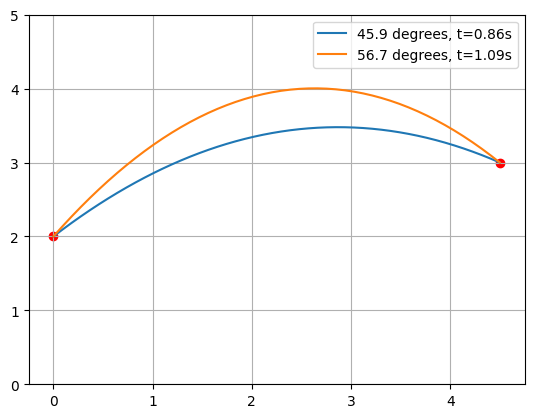

In [237]:
def y(x, params):
    y0, v0, g, theta, = params
    t = x/(v0*cos(theta))
    return y0 + v0*sin(theta)*t - g*t**2/2

y0 = 2
v0 = 7.5
g = 9.8

# hand-picked valid theta values (t>0)
params1 = (y0, v0, g, numerical_results[1])
params2 = (y0, v0, g, numerical_results[3])

x_range= np.linspace(0, 4.5)
plt.plot(x_range, y(x_range, params1), label=rf'{360*numerical_results[1]/(2*pi):.1f} degrees, t={time(numerical_results[1]):.2f}s')
plt.plot(x_range, y(x_range, params2), label=rf'{360*numerical_results[3]/(2*pi):.1f} degrees, t={time(numerical_results[3]):.2f}s')
plt.scatter((0, 4.5), (2, 3), color='red')
plt.ylim(0, 5)
plt.xlim(-.25, 4.75)
plt.grid()
plt.legend();

## Minimization/maximization

**Problem 5 (15 points).** Focus now on the trajectory that corresponds to the shortest overall time. Find the location of the highest point $(x_{max},y_{max})$ of the trajectory with the gradient descent method. This is a maximization problem that can be turned into a minimization problem by considering $-y(x)$ instead of $y(x)$.

Code the gradient descent method where the second argument is either a user-provided function to calculate the first derivative, or `None` in which case the method internally calculates the central finite difference (similarly to how you coded the Newton-Raphson method).

Solve the optimization problem in two ways: providing a function that analytically calculates the first derivative $y'(x)$ and with using the default central difference. Print out the location of the maximum $(x_{max},y_{max})$ and the time it takes to get to that point.


In [311]:
# minimization with fixed step size gradient descent
# Input:
# fun -- function to be minimized
# dfun -- its derivative or None (central finite difference used)
# alpha -- step size
# tol -- minimization is stopped when |f'(x)| < tol
# max_iter -- bound on the number of iterations
# Output:
# status -- =0, if the search was successful
# x -- the solution (last iterate)
# k -- number of iterations it took
# xlist -- the list of all iterates

def minimize_gradient_descent(fun, x0, dfun=None, alpha=0.01, tol=1e-4, max_iter=100, maxima = False, eps=0.001):
    status = 0
    i = 0

    if dfun==None:
        def dfun(x):
            return df_central(fun, x, eps=eps)
        
    steps = [x0]
    while abs(dfun(steps[-1])) > tol and i != max_iter:
        steps.append(steps[-1] - alpha*dfun(steps[-1])*(-1)**(maxima)) # negative dfun if flipped
        i += 1

    if i == max_iter:
        status = 1

    if steps[-1] == np.inf or steps[-1] == -np.inf:
        status = 2 # out of bounds error

    return status, steps[-1], i, steps

In [312]:
import sympy as sym

sym_x = sym.symbols('x')
th = numerical_results[1]

eqn = v0*sym_x*sym.sin(th)/(v0*sym.cos(th))- g*sym_x*sym_x/(2*v0**2*(sym.cos(th))**2)+2
print(eqn)
print(sym.diff(eqn, sym_x))

def dpreset_y(x_in):
    return np.float64(sym.diff(eqn, sym_x).replace(sym_x, x_in))

-0.179628966859762*x**2 + 1.03056645666566*x + 2
1.03056645666566 - 0.359257933719523*x


In [314]:
preset_y = lambda x: y(x, params1)

# numerical derivative #gives up early if eps is to small
status, result, i, steps = minimize_gradient_descent(preset_y, x0=1, alpha=0.1, max_iter=100000, maxima=True, eps=0.01)
x_no_deriv = result
print(status, i)

# analytical derivative
status, result, i, steps = minimize_gradient_descent(preset_y, x0=1, dfun=dpreset_y, alpha=0.1, max_iter=100000, maxima=True)
x_deriv = result
print(status, i)

0 19558
0 241


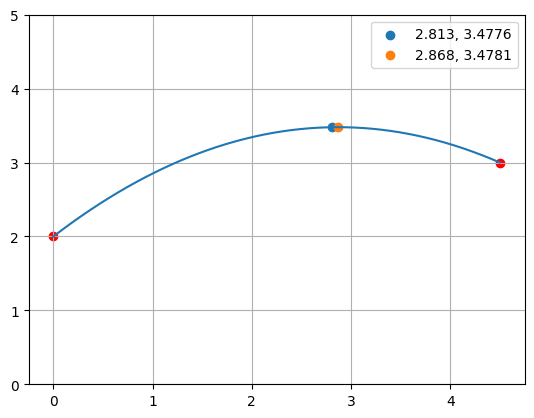

In [319]:
x_range= np.linspace(0, 4.5)

plt.scatter(x_no_deriv, preset_y(x_no_deriv), label = f'{x_no_deriv:.3f}, {preset_y(x_no_deriv):.4f}')
plt.scatter(x_deriv, preset_y(x_deriv), label = f'{x_deriv:.3f}, {preset_y(x_deriv):.4f}')
  

plt.plot(x_range, y(x_range, params1)) #label=rf'{360*numerical_results[1]/(2*pi):.1f} degrees, t={time(numerical_results[1]):.2f}s')
plt.scatter((0, 4.5), (2, 3), color='red')
plt.ylim(0, 5)
plt.xlim(-.25, 4.75)
plt.grid()
plt.legend();

&#169; Copyright 2025,  Michigan State University Board of Trustees